[Vertex AI: Qwik Start](https://www.cloudskillsboost.google/focuses/18940?catalog_rank=%7B%22rank%22%3A1%2C%22num_filters%22%3A0%2C%22has_search%22%3Atrue%7D&parent=catalog&search_id=23673079)

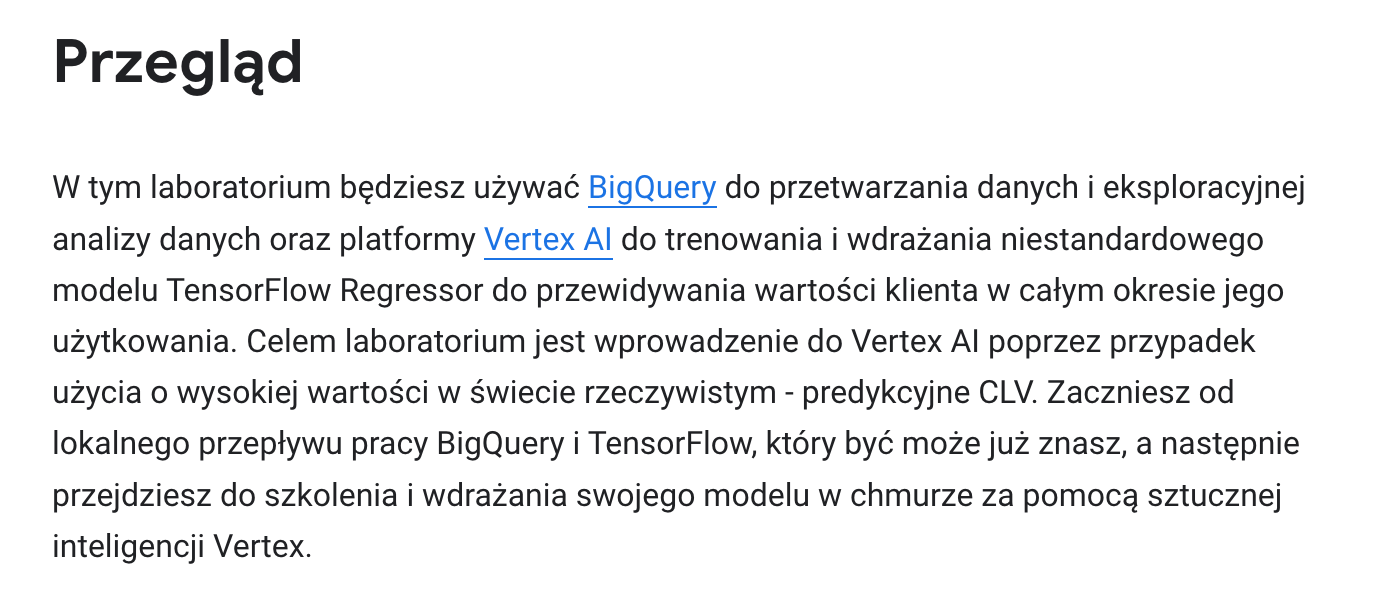

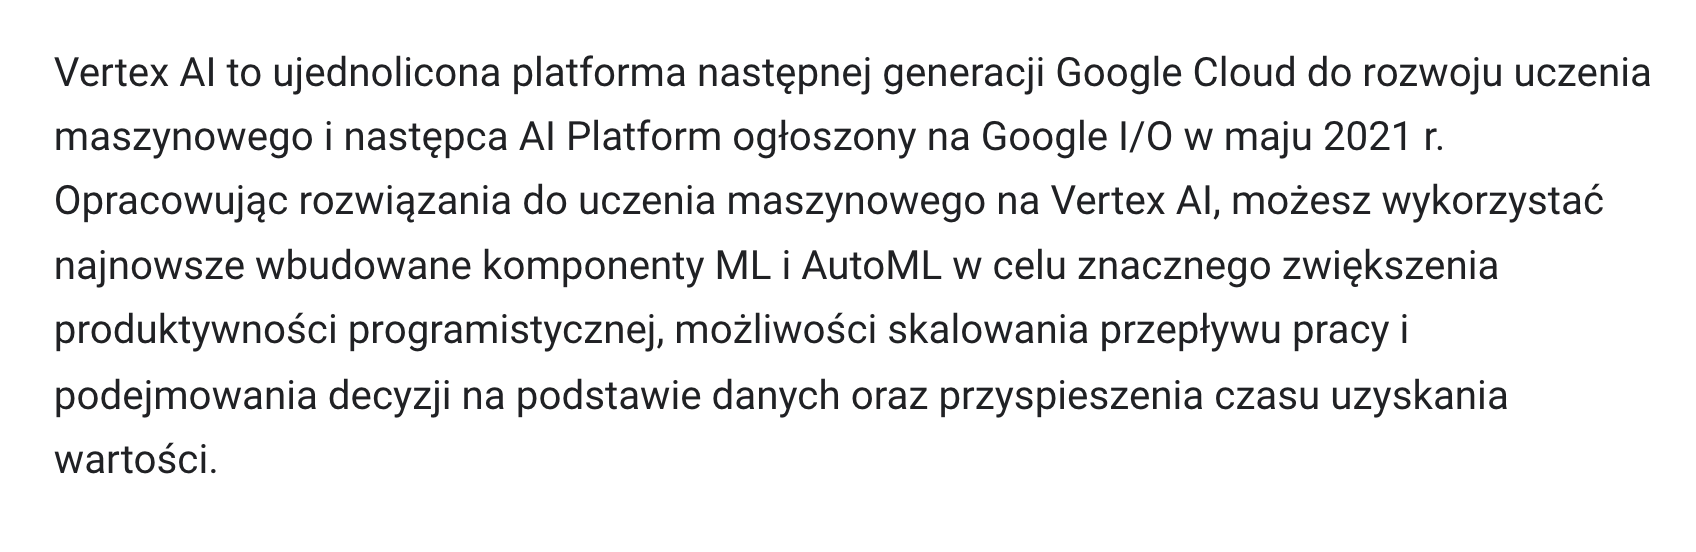

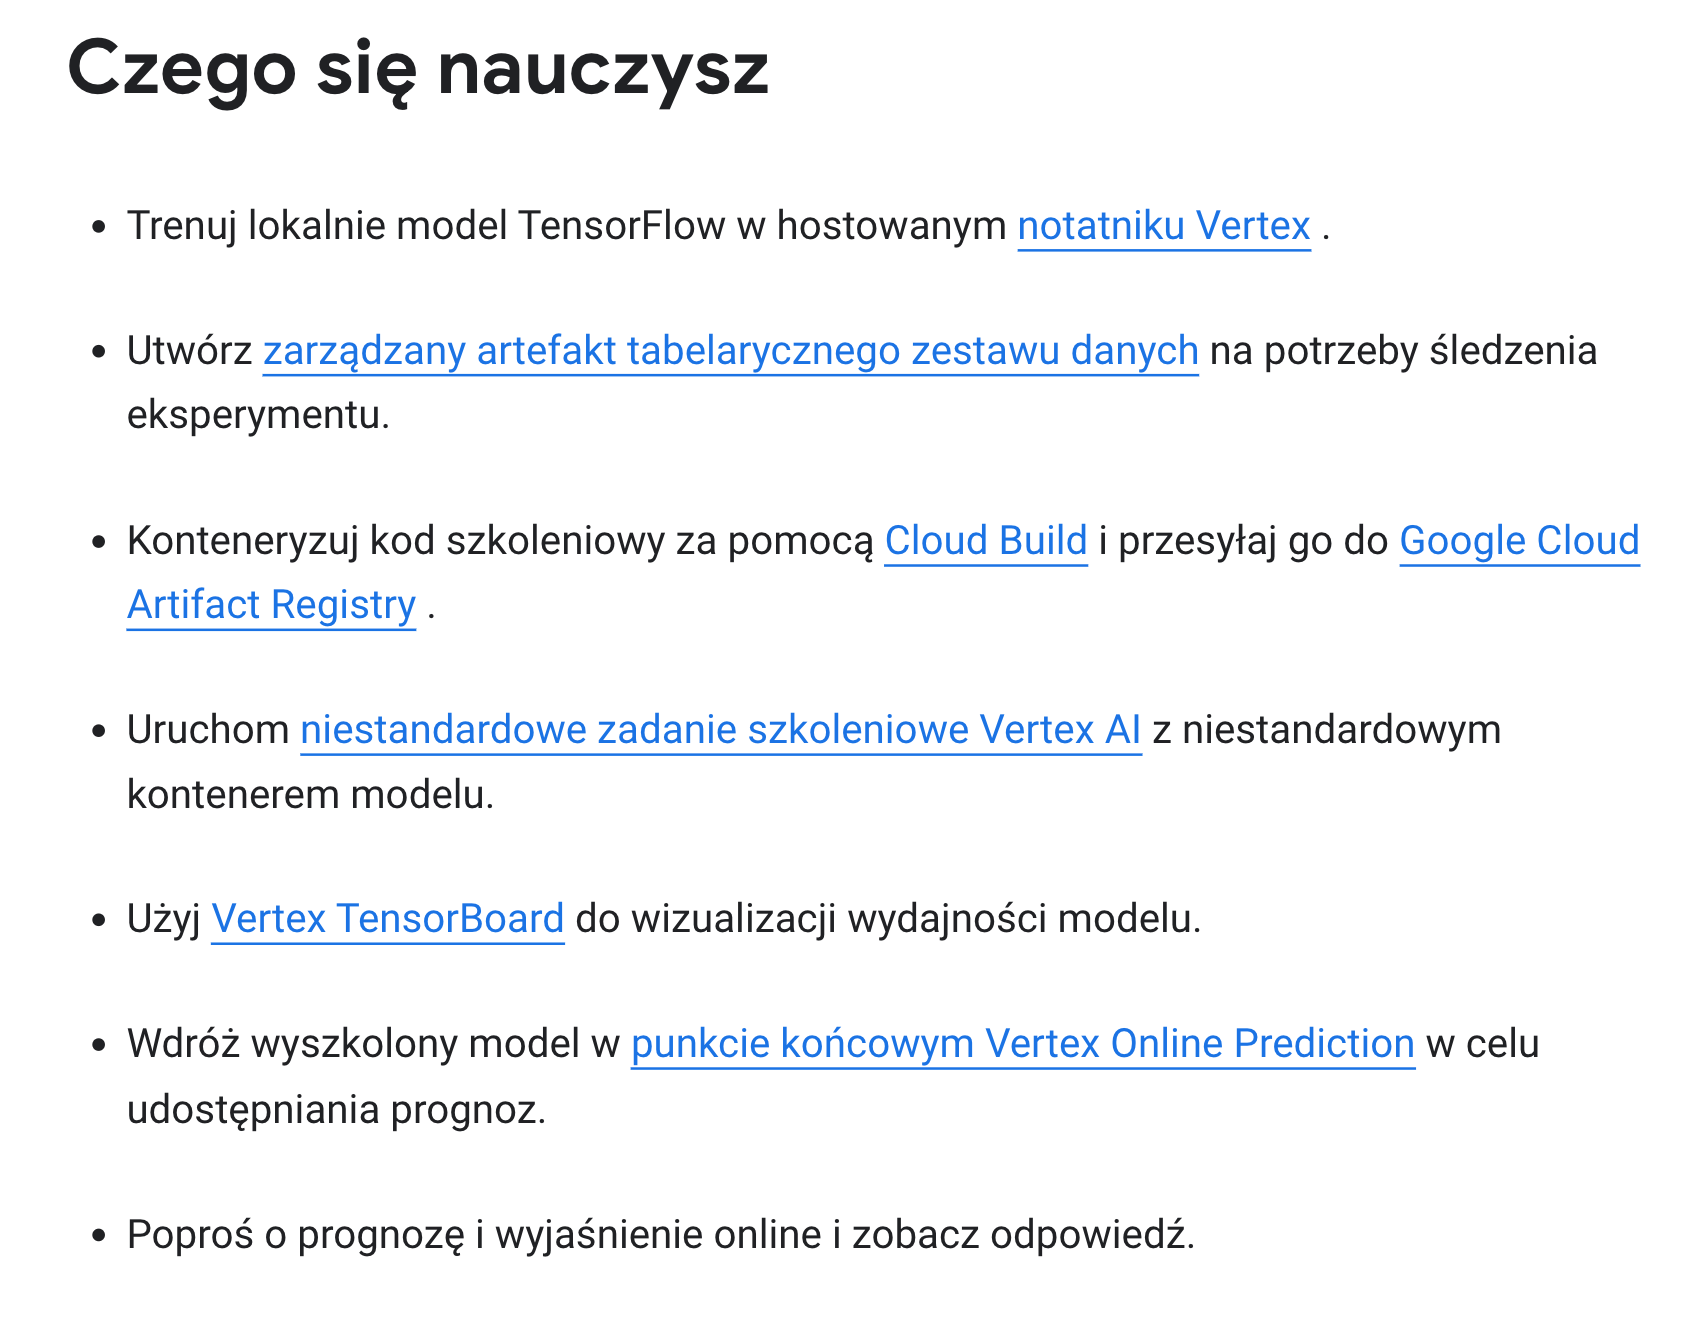

In [ ]:
# https://cloud.google.com/vertex-ai/docs/workbench/introduction

# https://cloud.google.com/vertex-ai/docs/training/using-managed-datasets

# https://cloud.google.com/build

# https://cloud.google.com/artifact-registry

# https://cloud.google.com/vertex-ai/docs/training/overview

# https://cloud.google.com/vertex-ai/docs/experiments/tensorboard-overview

# https://cloud.google.com/vertex-ai/docs/training-overview

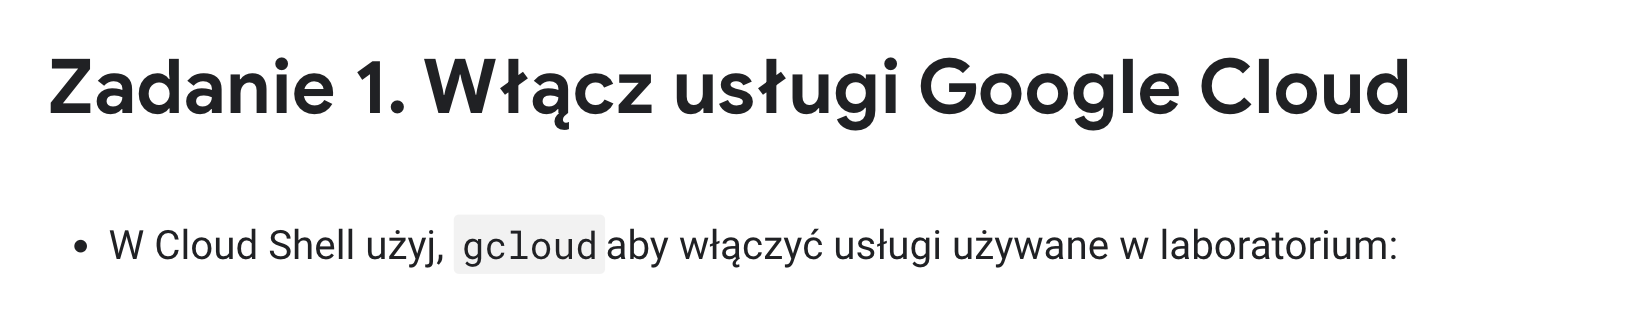

In [ ]:
gcloud services enable \
  compute.googleapis.com \
  iam.googleapis.com \
  iamcredentials.googleapis.com \
  monitoring.googleapis.com \
  logging.googleapis.com \
  notebooks.googleapis.com \
  aiplatform.googleapis.com \
  bigquery.googleapis.com \
  artifactregistry.googleapis.com \
  cloudbuild.googleapis.com \
  container.googleapis.com

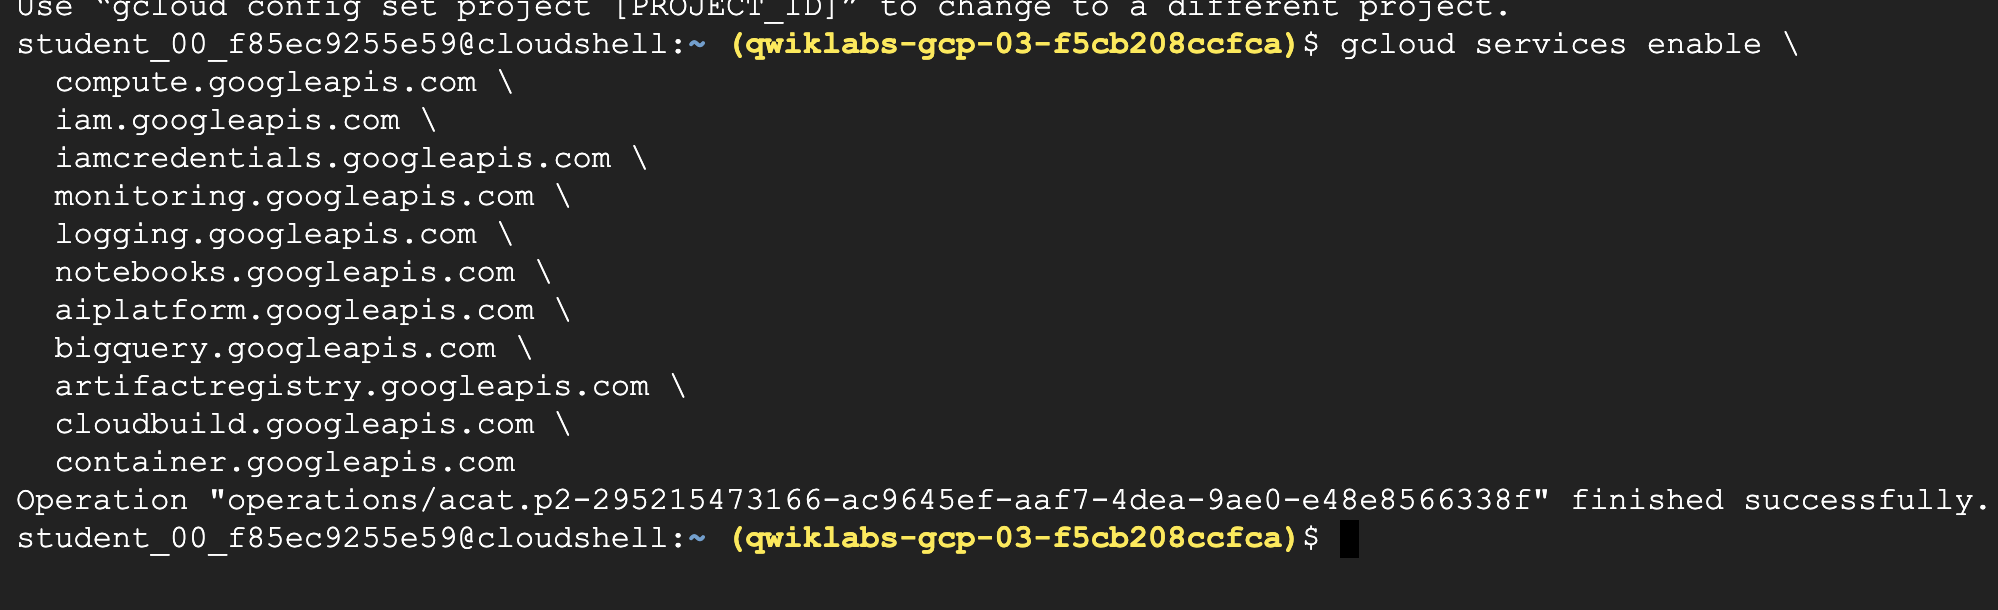

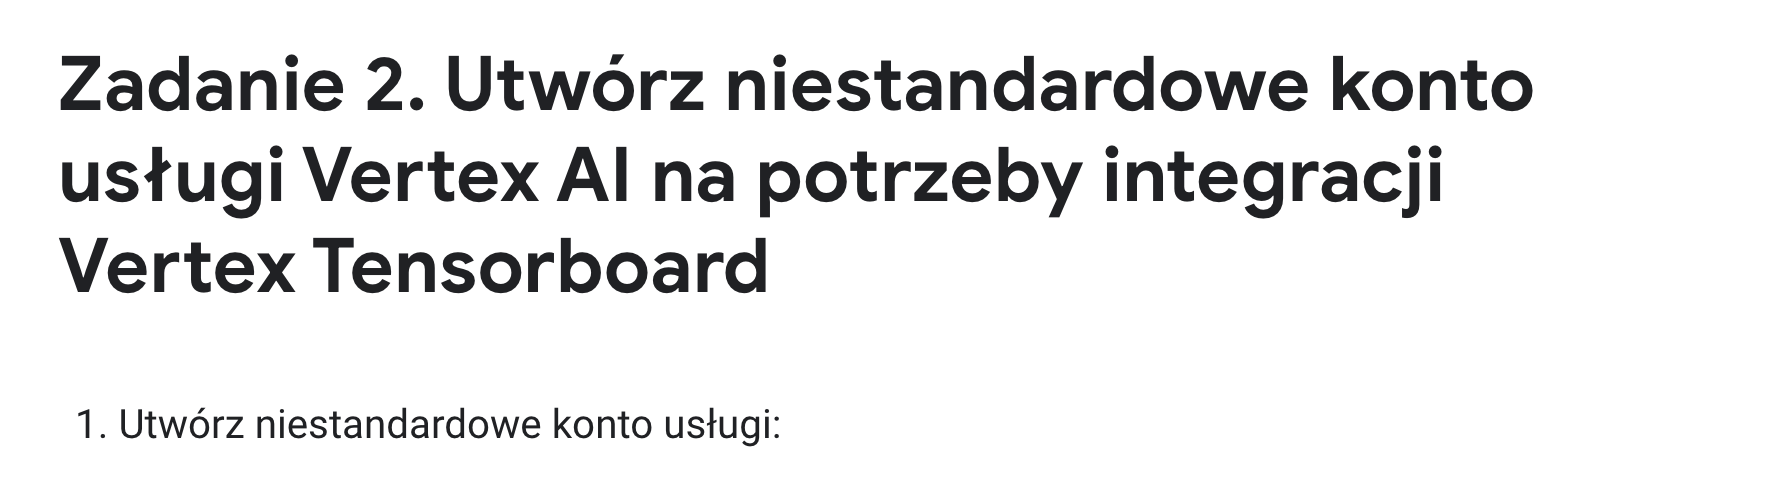

In [ ]:
SERVICE_ACCOUNT_ID=vertex-custom-training-sa
gcloud iam service-accounts create $SERVICE_ACCOUNT_ID  \
    --description="A custom service account for Vertex custom training with Tensorboard" \
    --display-name="Vertex AI Custom Training"

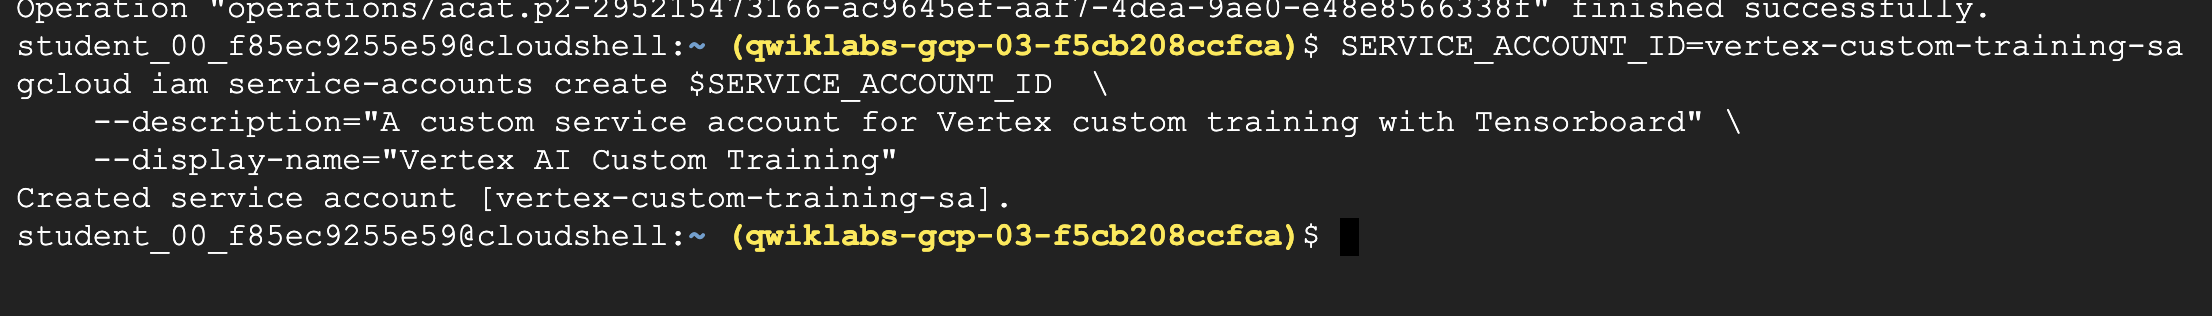

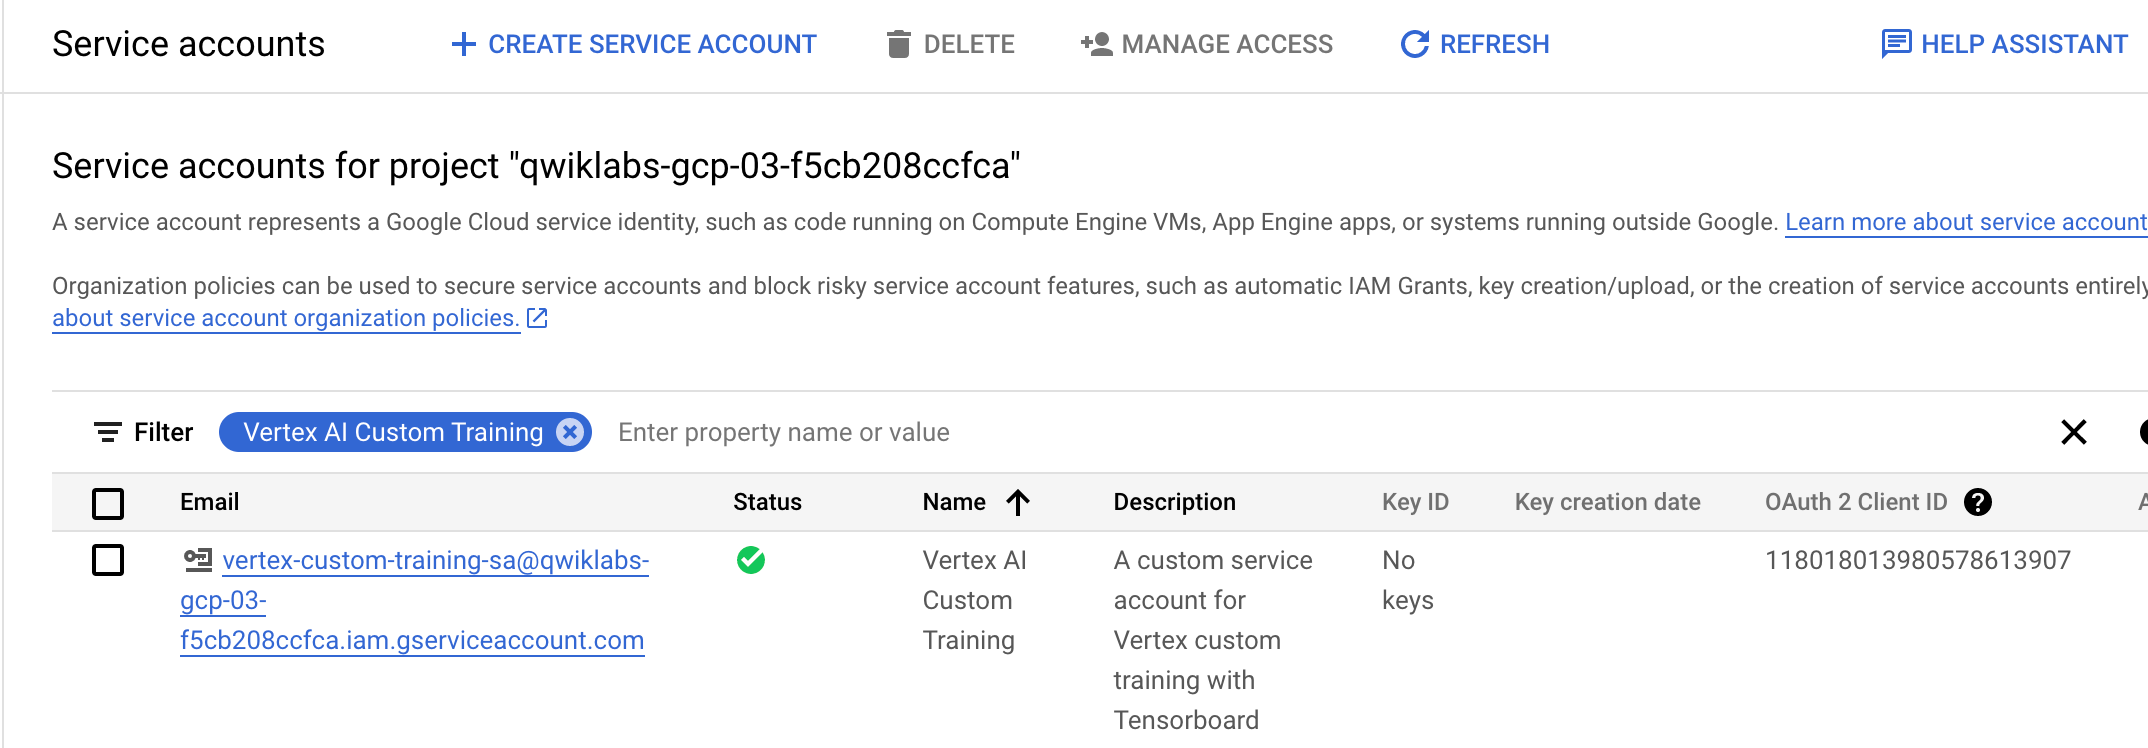

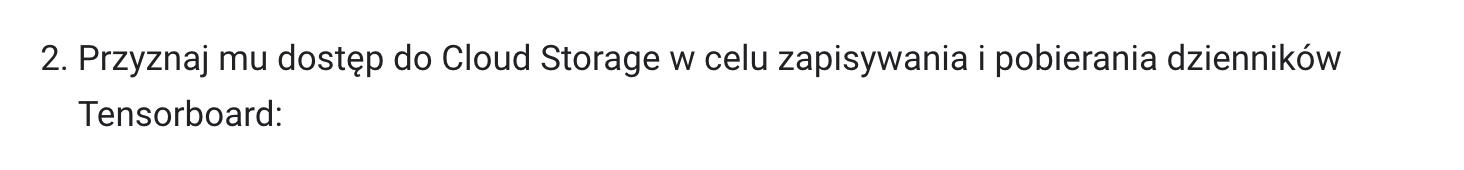

In [ ]:
PROJECT_ID=$(gcloud config get-value core/project)
gcloud projects add-iam-policy-binding $PROJECT_ID \
    --member=serviceAccount:$SERVICE_ACCOUNT_ID@$PROJECT_ID.iam.gserviceaccount.com \
    --role="roles/storage.admin"

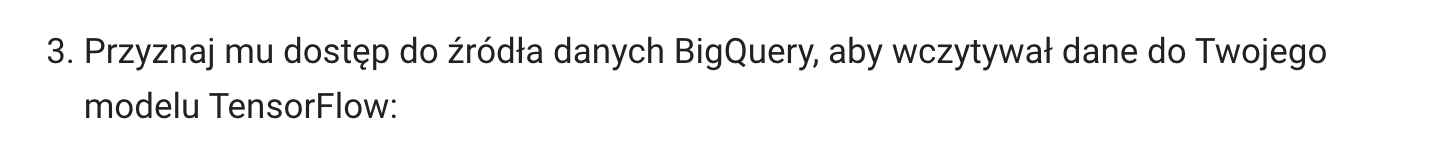

In [ ]:
gcloud projects add-iam-policy-binding $PROJECT_ID \
    --member=serviceAccount:$SERVICE_ACCOUNT_ID@$PROJECT_ID.iam.gserviceaccount.com \
    --role="roles/bigquery.admin"

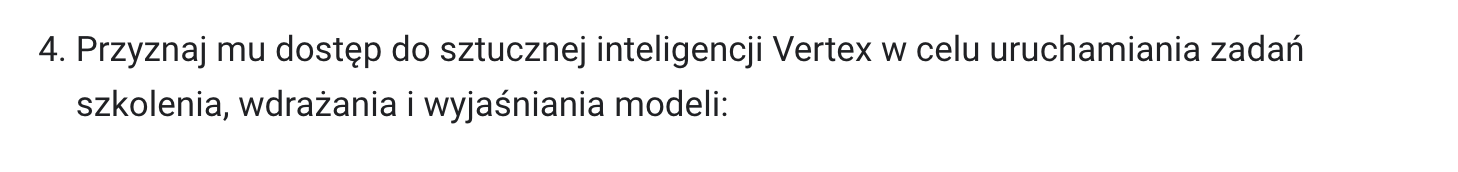

In [ ]:
gcloud projects add-iam-policy-binding $PROJECT_ID \
    --member=serviceAccount:$SERVICE_ACCOUNT_ID@$PROJECT_ID.iam.gserviceaccount.com \
    --role="roles/aiplatform.user"

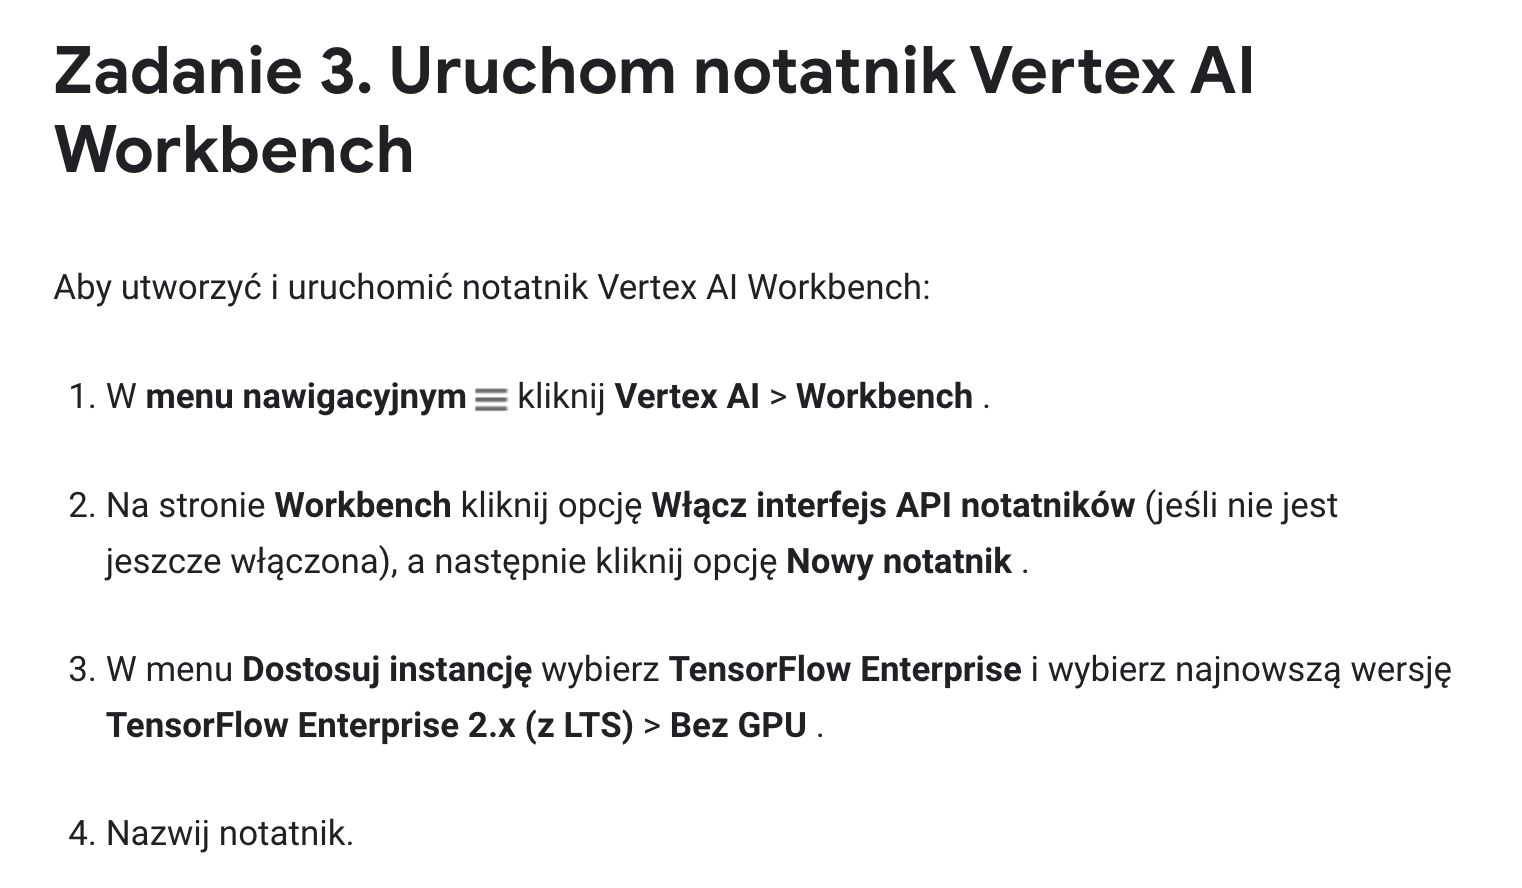

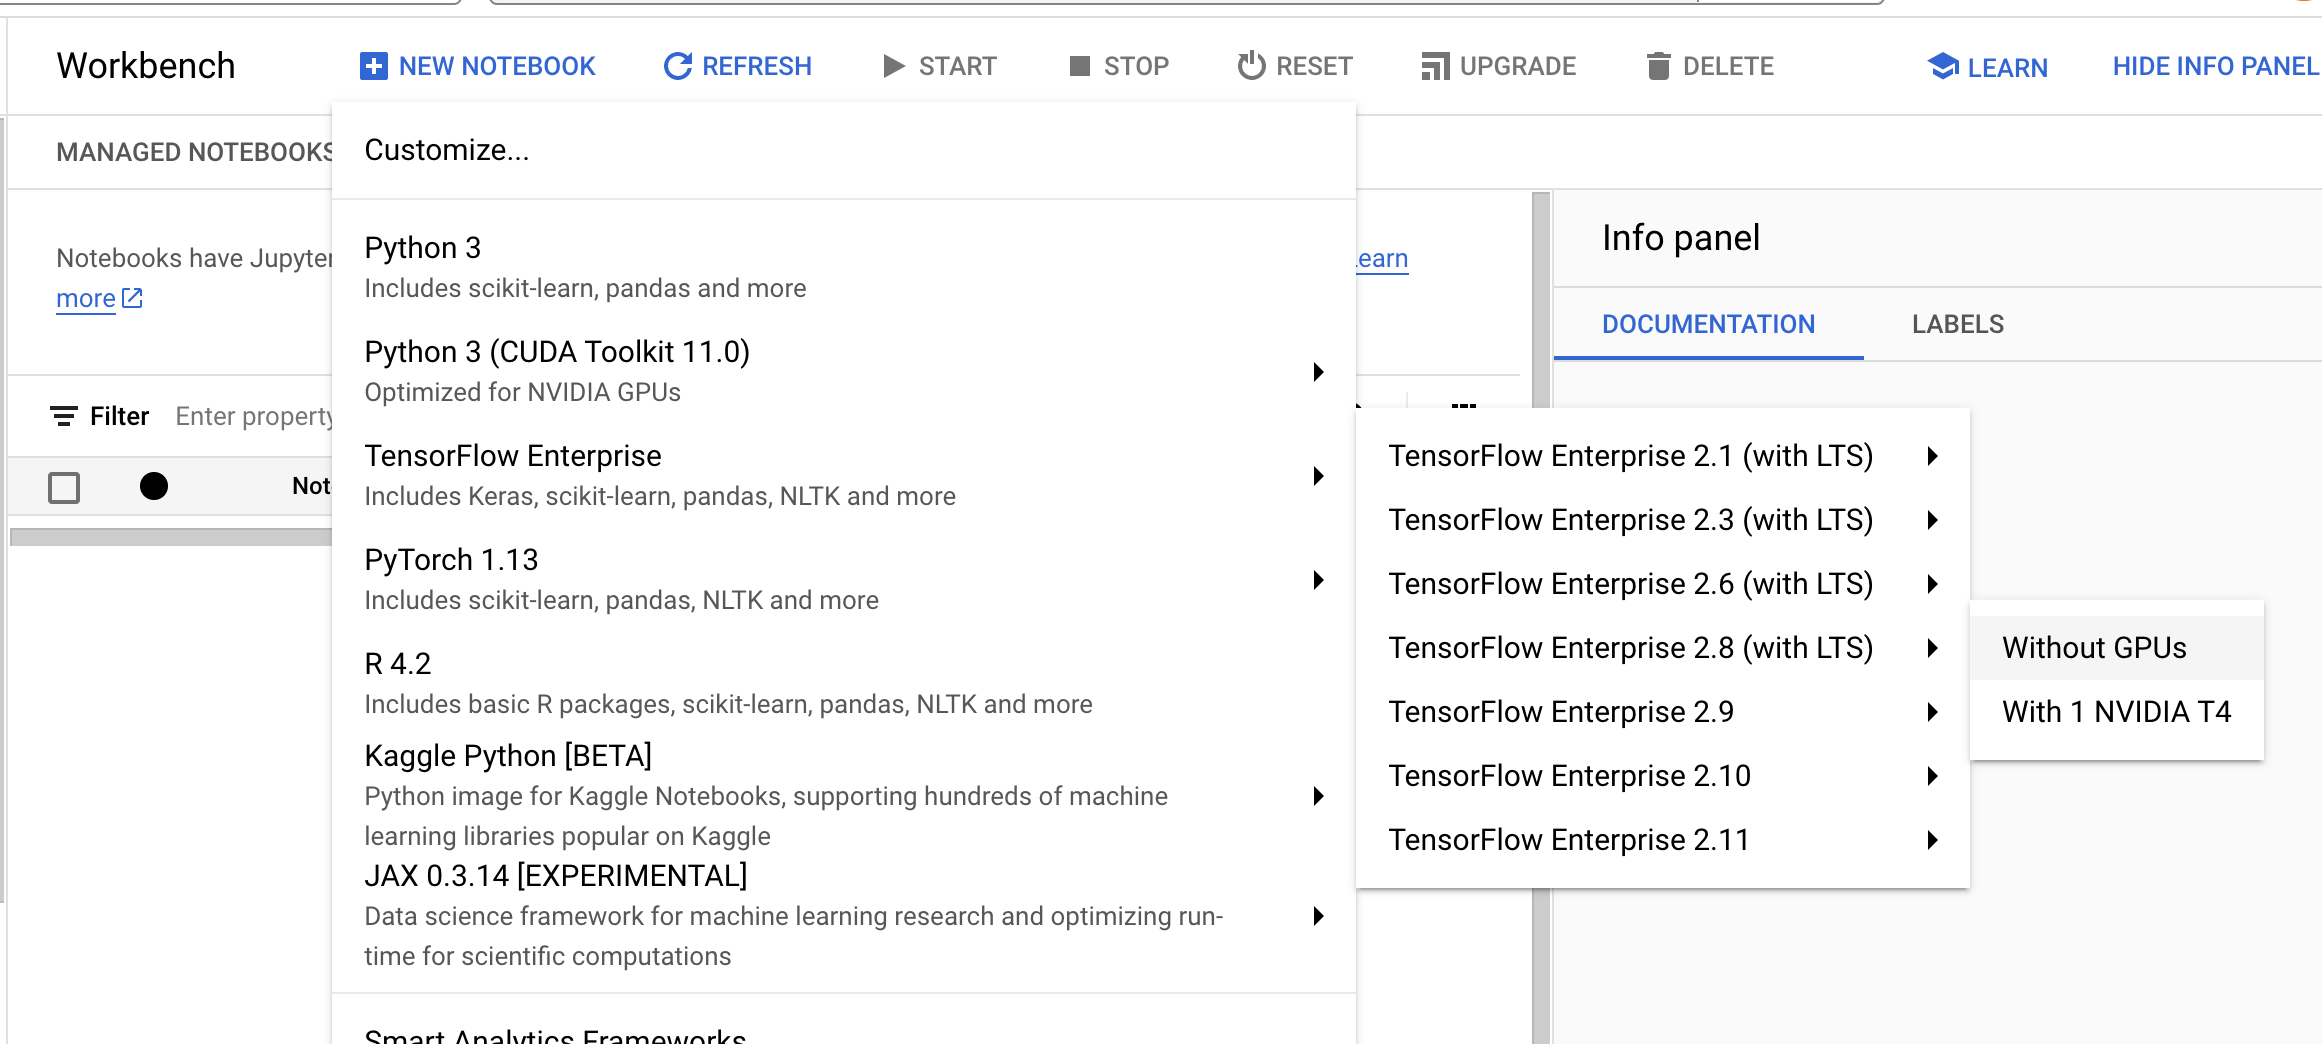

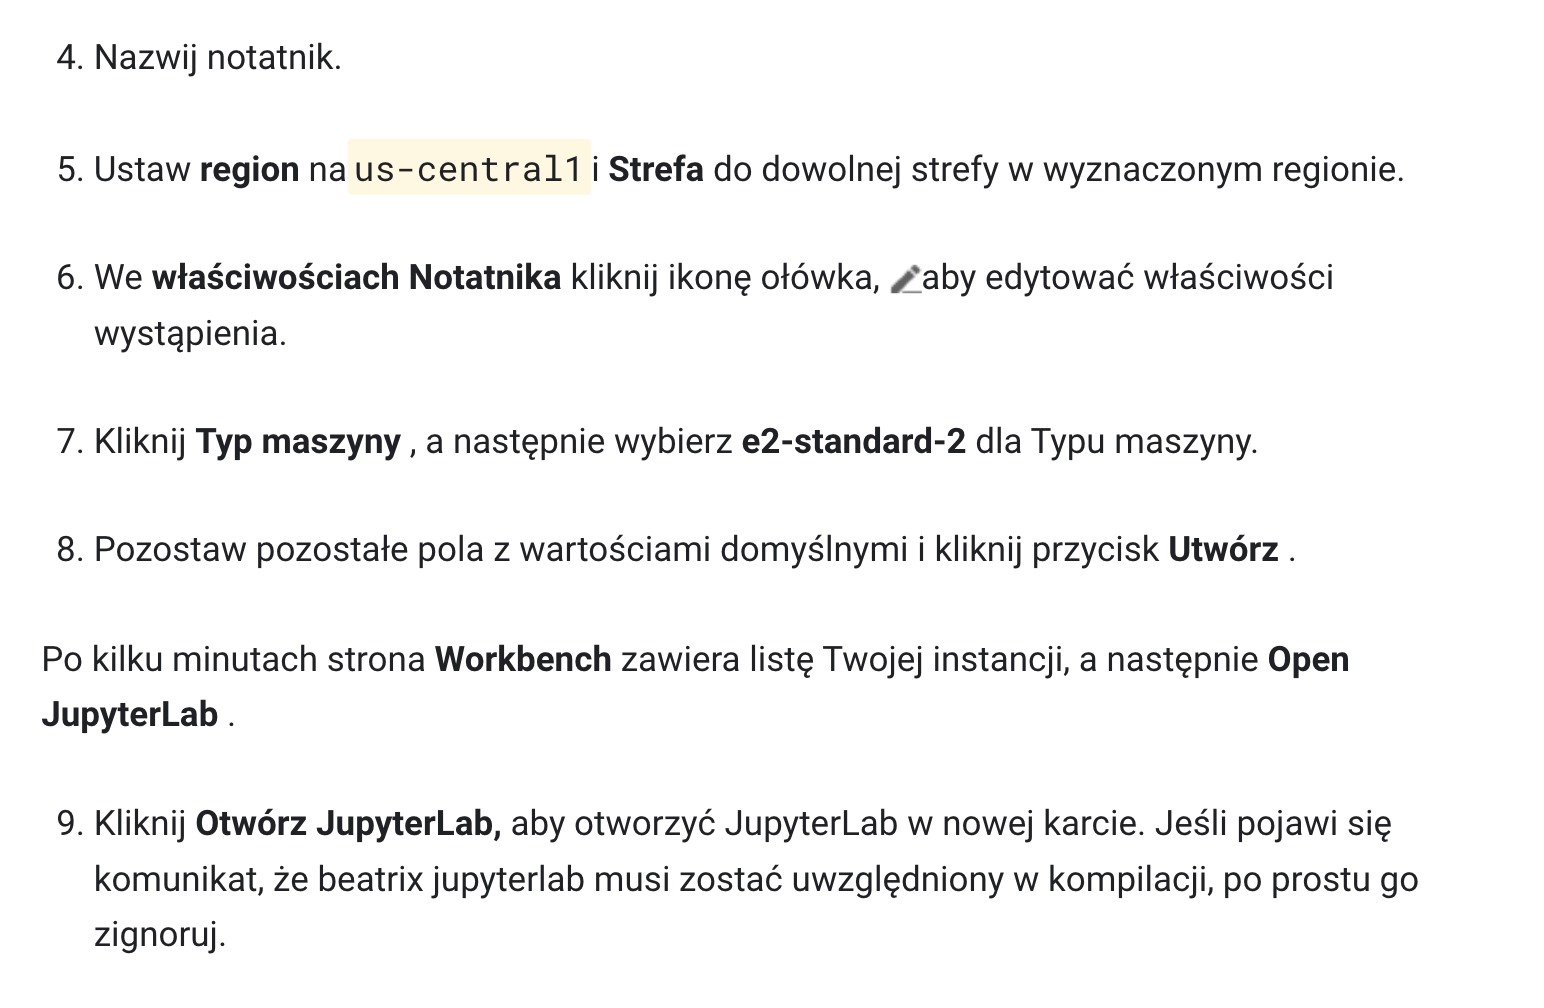

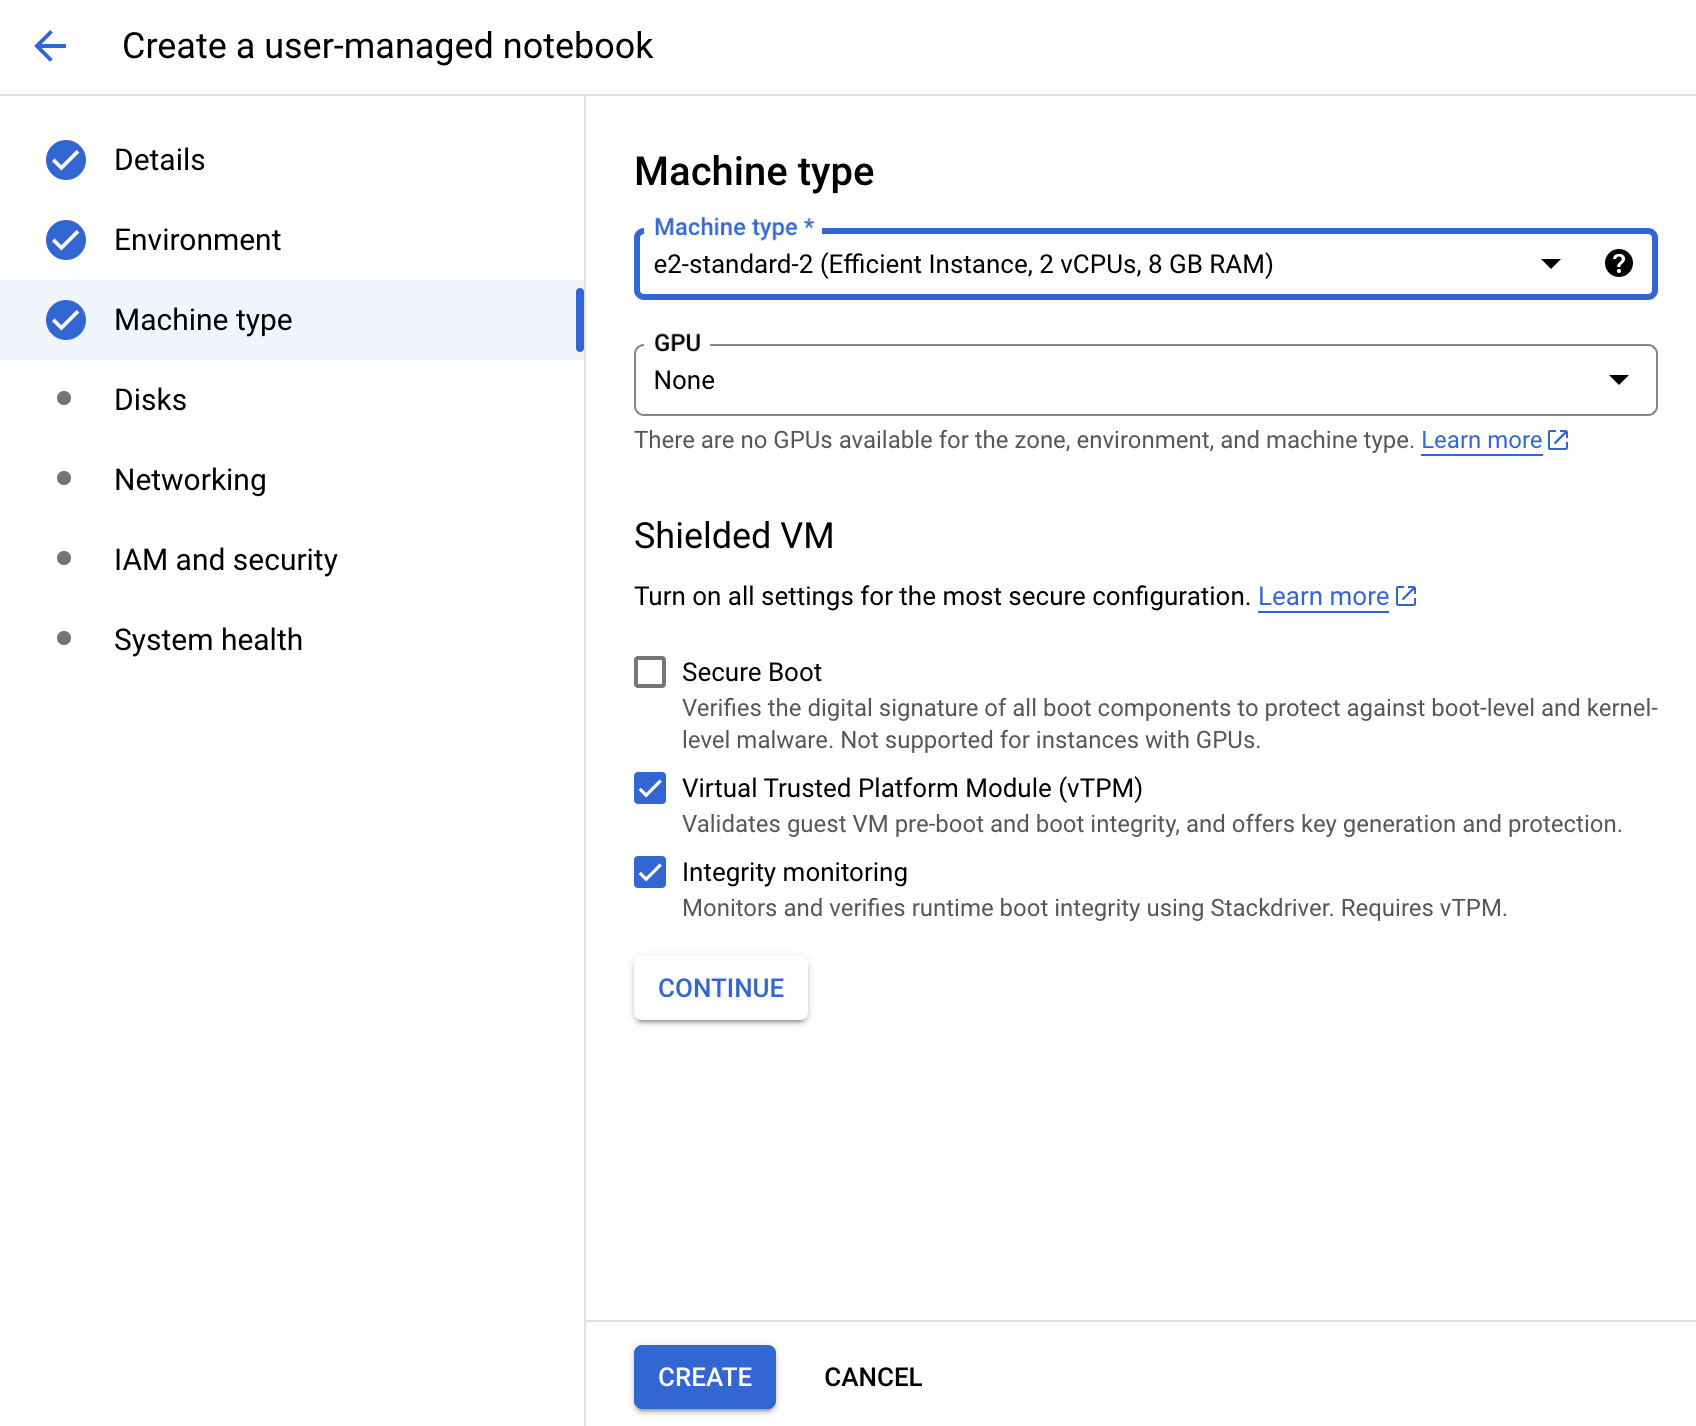

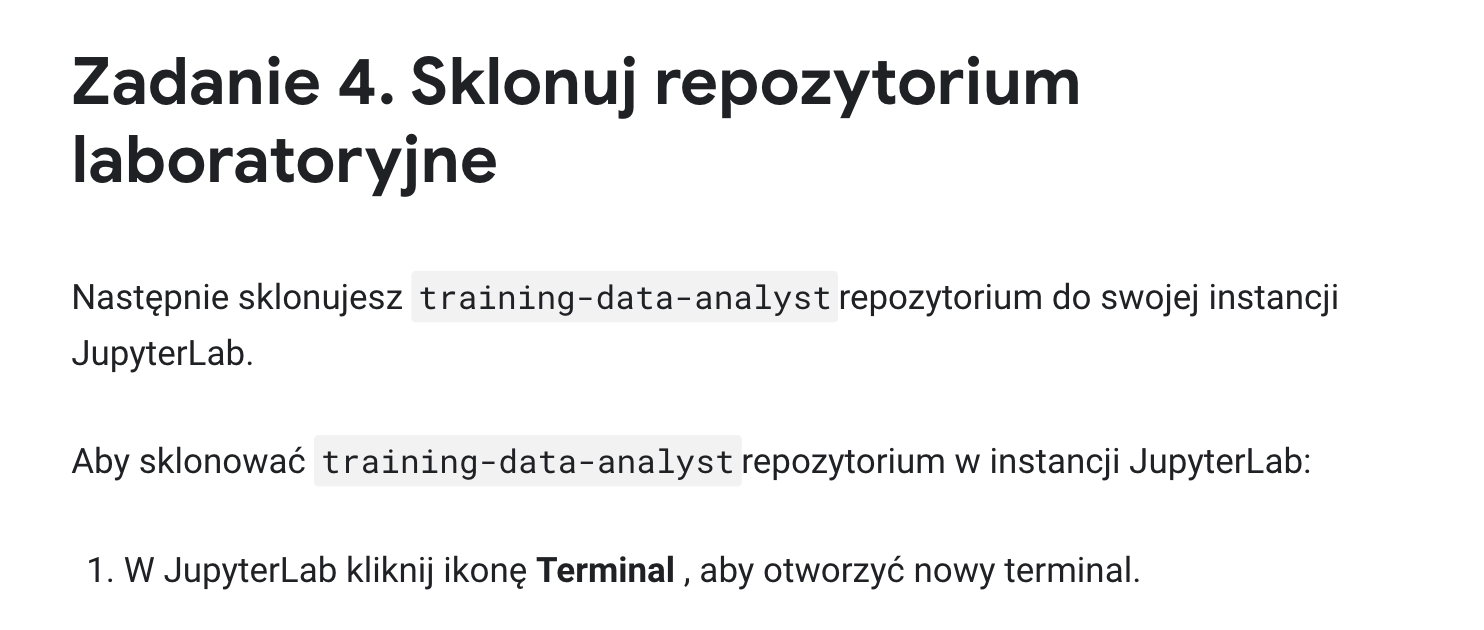

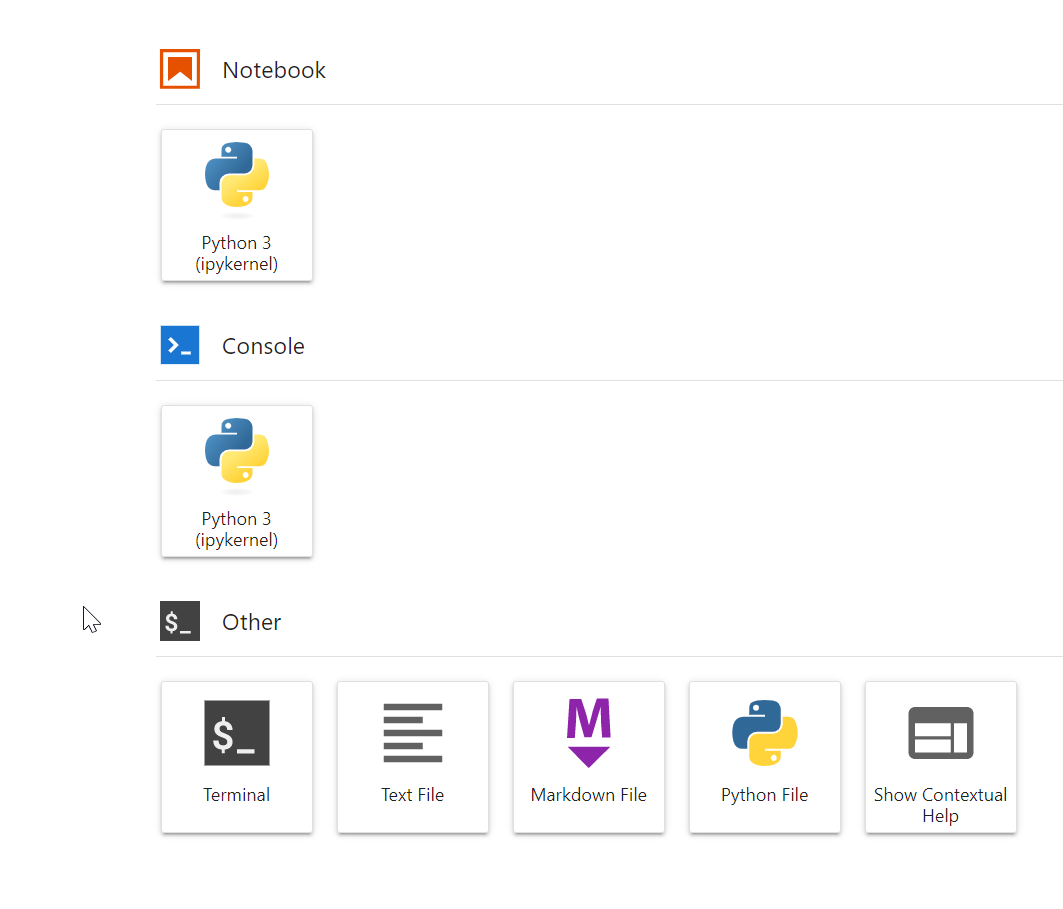

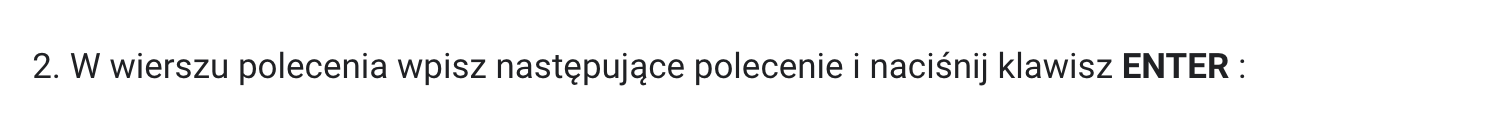

In [ ]:
git clone https://github.com/GoogleCloudPlatform/training-data-analyst

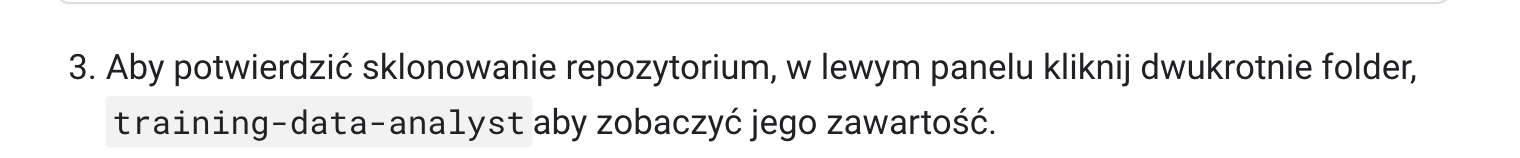

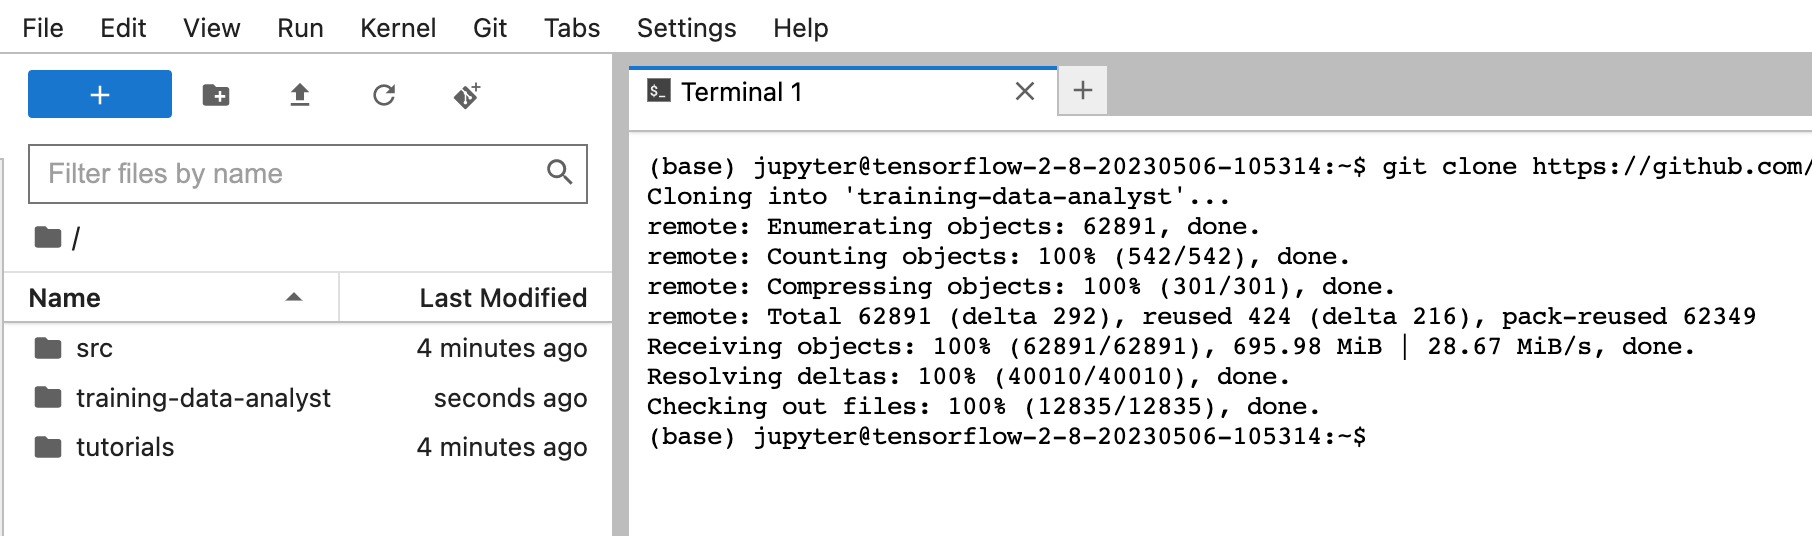

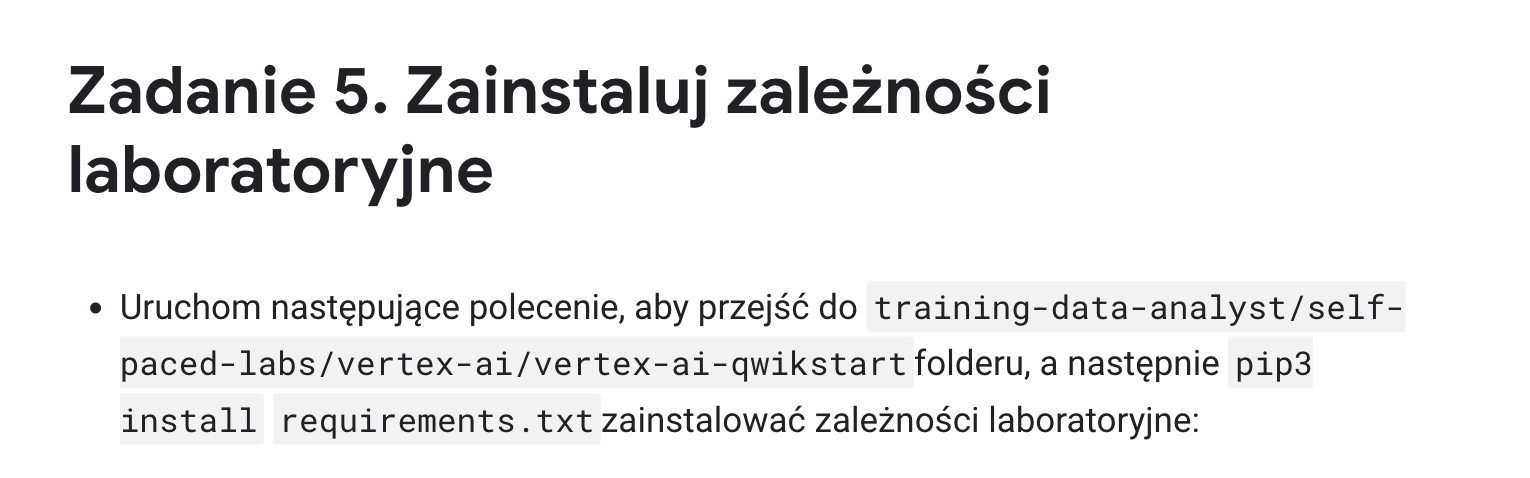

In [ ]:
cd training-data-analyst/self-paced-labs/vertex-ai/vertex-ai-qwikstart
pip3 install --user -r requirements.txt

`requirements.txt`

In [ ]:
tensorflow>=2.11.0
pyarrow==6.0.1
httplib2>=0.20.4
grpcio-status>=1.38.1
google-api-python-client>=1.8.0
apache-beam>=2.28.0
google-cloud-aiplatform[tensorboard]>=1.8.0
six==1.15.0
wget==3.2
xlrd==2.0.1
openpyxl==3.0.7

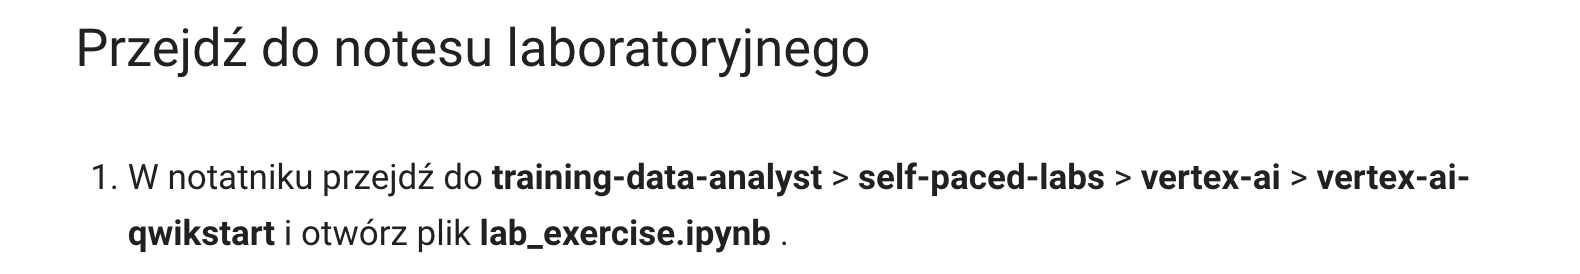

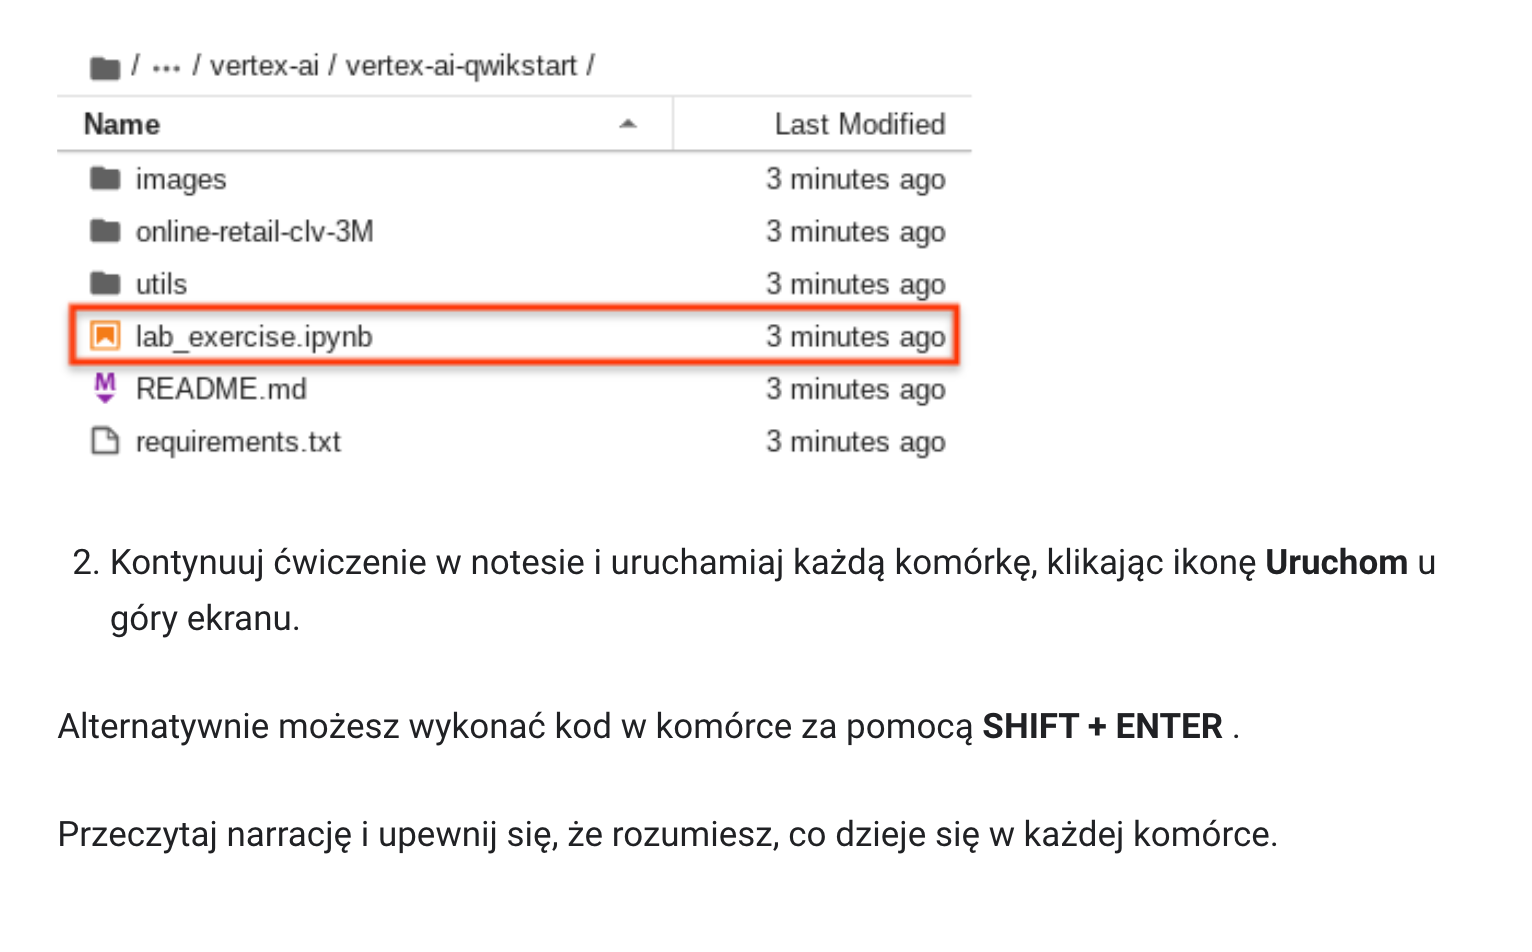

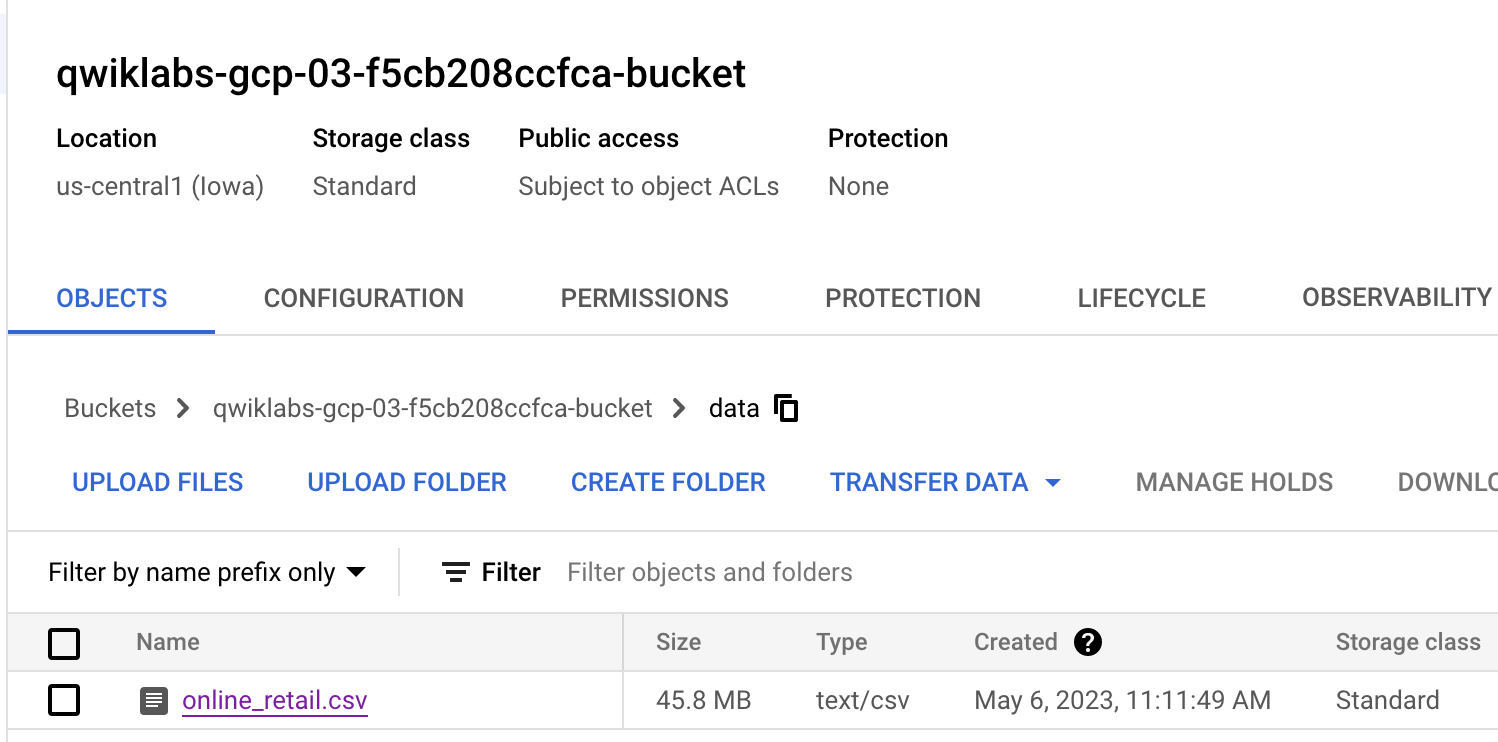

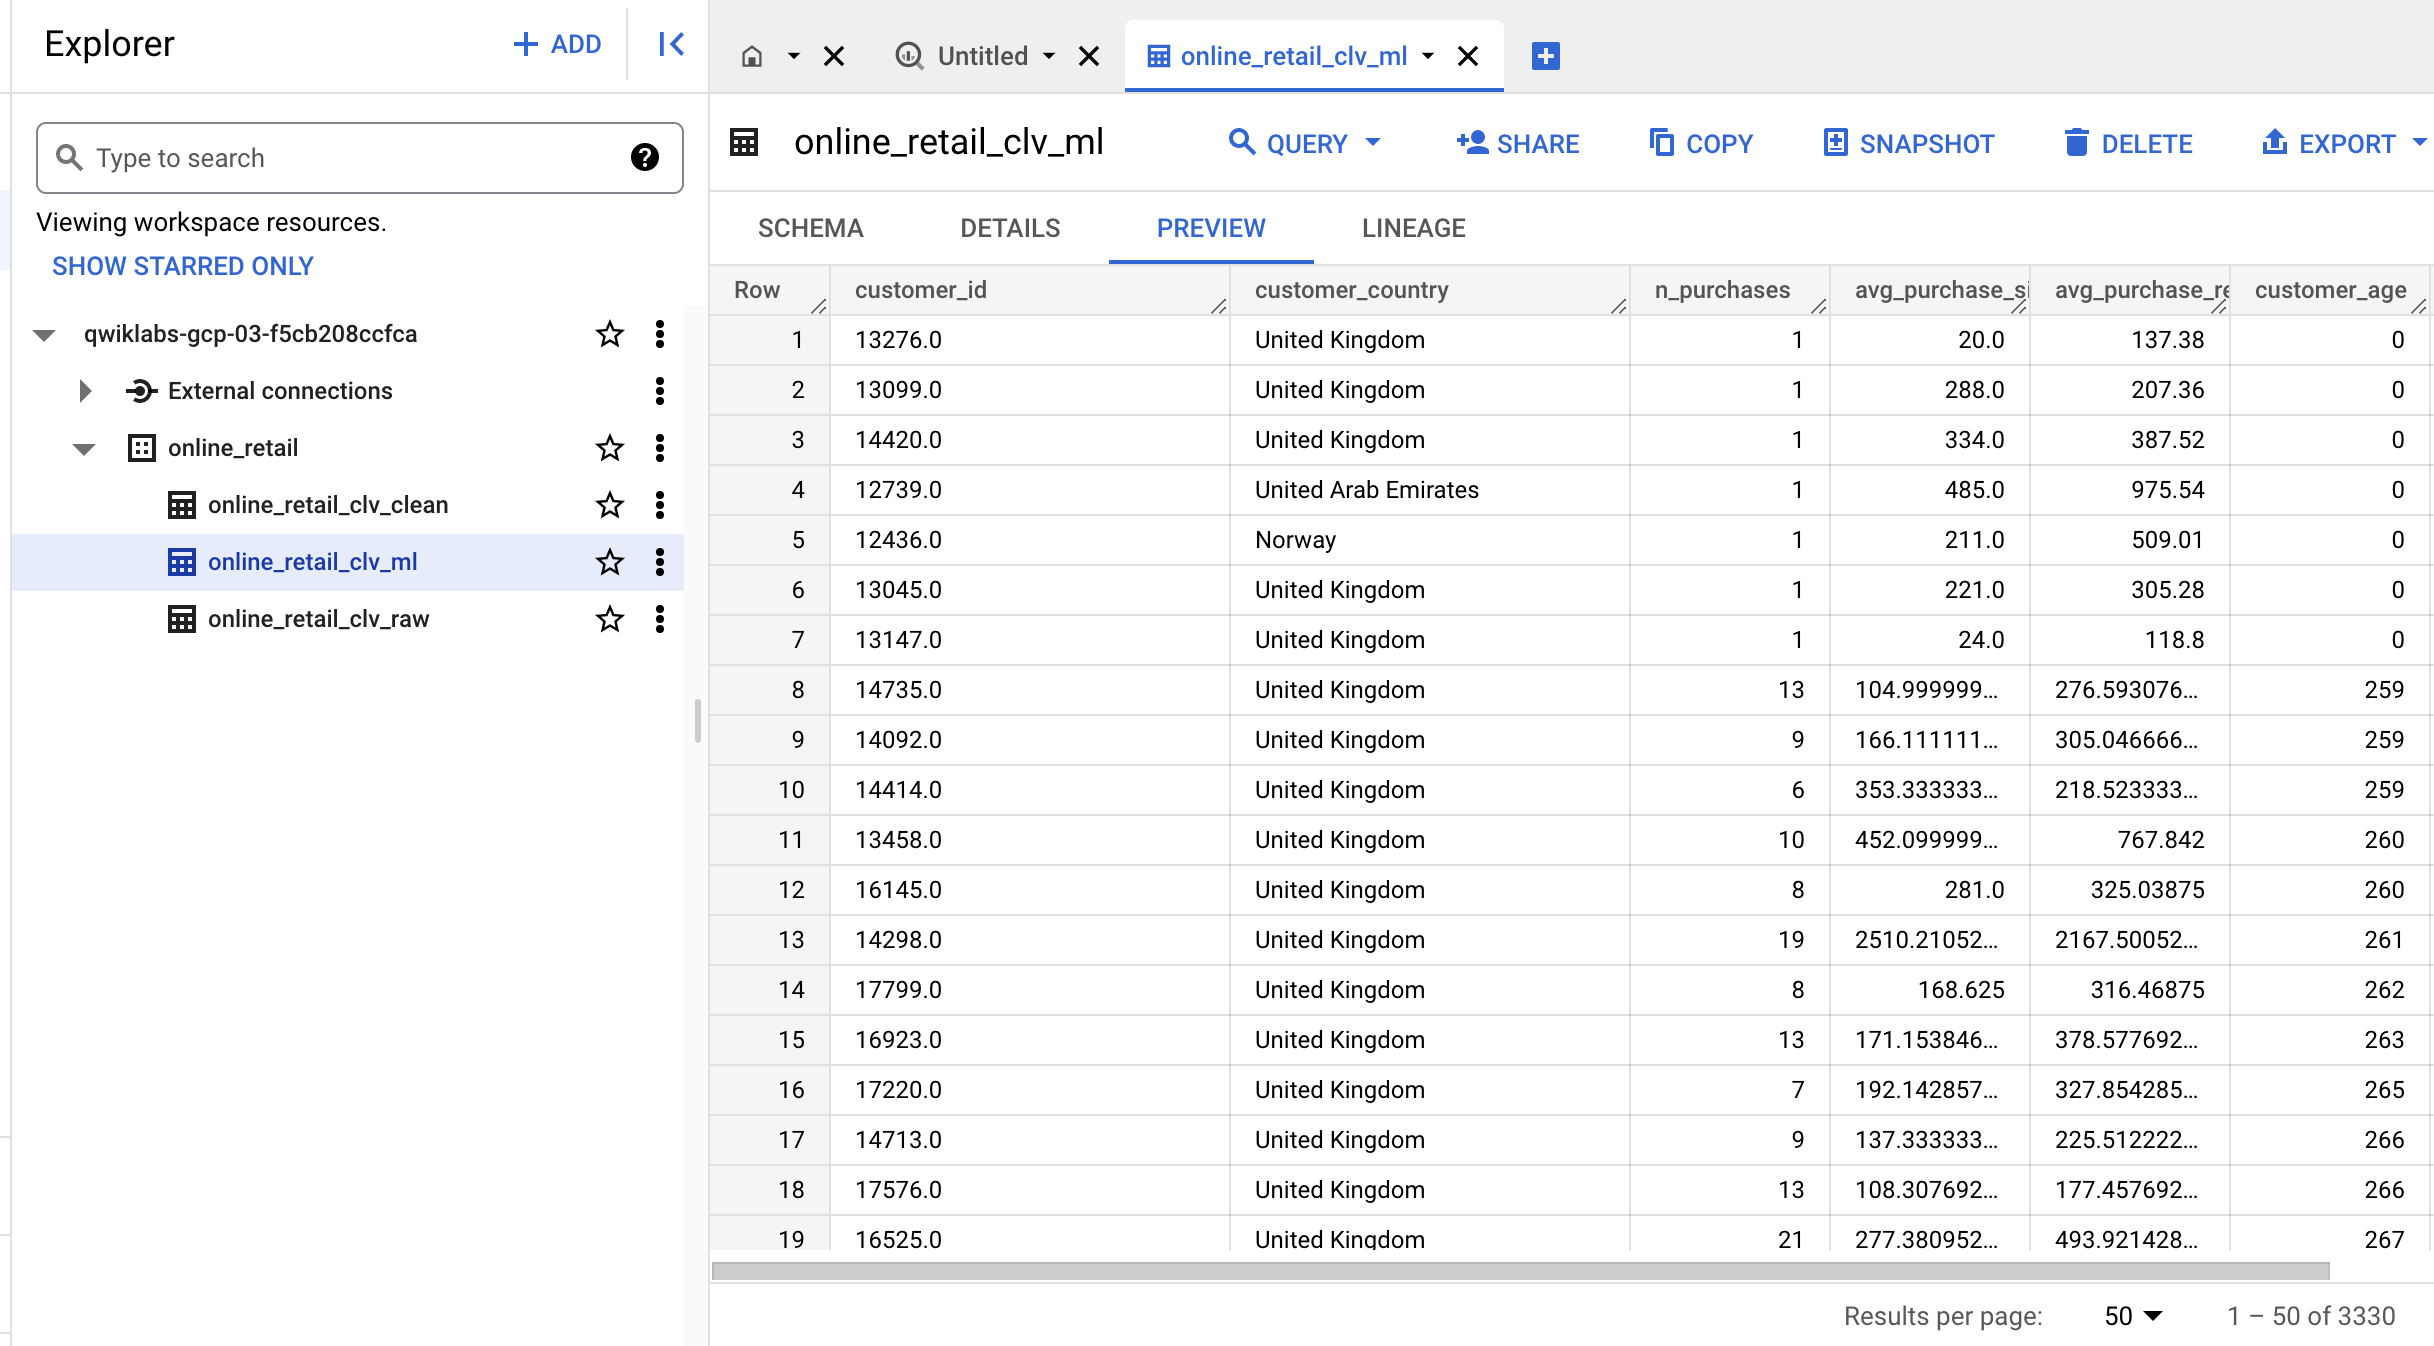

`data_download.py`

In [ ]:
import os
import logging
import shutil
import wget
import argparse
import pandas as pd
from google.cloud import storage
from google.cloud import bigquery
from google.cloud.exceptions import NotFound, Conflict

from dataset_schema import table_schema
from dataset_clean import dataset_clean_query
from dataset_ml import dataset_ml_query

LOCAL_PATH ="./data"
FILENAME = "online_retail"


def download_url2gcs(args):
    """
    args:
    """
    
    #set GCS client.
    client = storage.Client()
    
    # Retrieve GCS bucket.
    bucket = client.get_bucket(args.GCS_BUCKET)
    blob = bucket.blob("data/online_retail.csv")

    #See if file already exists.
    if blob.exists() == False:
        try:
            os.mkdir(LOCAL_PATH)
            logging.info('Downloading xlsx file...')            
            local_xlsx = wget.download(args.URL, out=f"{LOCAL_PATH}/{FILENAME}.xlsx")
            logging.info('Converting xlsx -> csv...')            
            df = pd.read_excel(local_xlsx)            
            df.to_csv(f"{LOCAL_PATH}/{FILENAME}.csv", index=False)
            logging.info('Uploading local csv file to GCS...')
            blob.upload_from_filename(f"{LOCAL_PATH}/{FILENAME}.csv")
            logging.info('Copied local csv file to GCS.')
            # Delete all contents of a directory using shutil.rmtree() and  handle exceptions.
            try:
                shutil.rmtree(LOCAL_PATH)
                logging.info('Cleaning up local tmp data directory...')
            except:
                logging.error('Error while deleting local tmp data directory.')

        #print error if file doesn't exist.
        except BaseException as error:
            logging.error('An exception occurred: {}'.format(error))
            
    #print error if file already exists in GCS.
    else:
        logging.warning('File already exists in GCS.')
            

def upload_gcs2bq(args, schema):
    """
    args:
    schema:
    """    
    # Construct a BigQuery client object.
    client = bigquery.Client()
    
    # Construct a full Dataset object to send to the API.
    logging.info('Initializing BigQuery dataset.')
    dataset = bigquery.Dataset(f"{args.PROJECT_ID}.{args.BQ_DATASET_NAME}")

    try:
        # Send the dataset to the API for creation, with an explicit timeout.
        # Raises google.api_core.exceptions.Conflict if the Dataset already
        # exists within the project.
        dataset = client.create_dataset(dataset, timeout=30)  # Make an API request.
        # Specify the geographic location where the dataset should reside.
        dataset.location = args.BQ_LOCATION
    except Conflict:
        logging.warning('Dataset %s already exists, not creating.', dataset.dataset_id)
    else:
        logging.info("Created dataset %s.%s", client.project, dataset.dataset_id)           
    
    try:
        URI = f"gs://{args.GCS_BUCKET}/data/{FILENAME}.csv"
        RAW_TABLE_ID = f"{args.PROJECT_ID}.{args.BQ_DATASET_NAME}.{args.BQ_RAW_TABLE_NAME}"
        
        # Load job.
        job_config = bigquery.LoadJobConfig(
            schema=schema,
            skip_leading_rows=1,
            allow_jagged_rows=True,
            write_disposition="WRITE_TRUNCATE",
            source_format=bigquery.SourceFormat.CSV)        
        load_job = client.load_table_from_uri(source_uris=URI, destination=RAW_TABLE_ID, job_config=job_config)
        logging.info('BQ raw dataset load job starting...')        
        load_job.result()  # Waits for the job to complete.
        logging.info('BQ raw dataset load job complete.')
    except BaseException as error:
        logging.error('An exception occurred: {}'.format(error))
    
    destination_table = client.get_table(RAW_TABLE_ID)  # Make an API request.
    logging.info("Loaded %s rows into %s.",destination_table.num_rows, RAW_TABLE_ID)
    

def make_dataset_clean_bq(args, query: str):
    """
    args:
    query:
    """
    client = bigquery.Client()
    CLEAN_TABLE_ID = f"{args.PROJECT_ID}.{args.BQ_DATASET_NAME}.{args.BQ_CLEAN_TABLE_NAME}"
    RAW_TABLE_ID = f"{args.PROJECT_ID}.{args.BQ_DATASET_NAME}.{args.BQ_RAW_TABLE_NAME}"    
    
    clean_query = query.replace("@CLEAN_TABLE_ID", CLEAN_TABLE_ID).replace("@RAW_TABLE_ID", RAW_TABLE_ID)

    logging.info('BQ make clean dataset starting...')
    try:
      job = client.query(clean_query)
      _ = job.result()
      logging.info('BQ make clean dataset complete')
    except BaseException as error:
        logging.error('An exception occurred: {}'.format(error))
    
    destination_table = client.get_table(CLEAN_TABLE_ID)  # Make an API request.
    logging.info("Loaded %s rows into %s.",destination_table.num_rows, CLEAN_TABLE_ID)    

    
def make_dataset_ml_bq(args, query: str):
    """
    args:
    query:
    """
    client = bigquery.Client()
    ML_TABLE_ID = f"{args.PROJECT_ID}.{args.BQ_DATASET_NAME}.{args.BQ_ML_TABLE_NAME}"
    CLEAN_TABLE_ID = f"{args.PROJECT_ID}.{args.BQ_DATASET_NAME}.{args.BQ_CLEAN_TABLE_NAME}"    
    
    ml_query = query.replace("@ML_TABLE_ID", ML_TABLE_ID).replace("@CLEAN_TABLE_ID", CLEAN_TABLE_ID)    

    logging.info('BQ make ML dataset starting...')
    try:
      job = client.query(ml_query)
      _ = job.result()
      logging.info('BQ make ML dataset complete')
    except BaseException as error:
        logging.error('An exception occurred: {}'.format(error))
    
    destination_table = client.get_table(ML_TABLE_ID)  # Make an API request.
    logging.info("Loaded %s rows into %s.",destination_table.num_rows, ML_TABLE_ID)
    
        
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument("--PROJECT_ID", dest="PROJECT_ID", type=str, required=True)
    parser.add_argument("--GCS_BUCKET", dest="GCS_BUCKET", type=str, required=True)
    parser.add_argument("--URL", dest="URL", type=str, required=True)
    parser.add_argument("--BQ_DATASET_NAME", dest="BQ_DATASET_NAME", type=str, default="online_retail")
    parser.add_argument("--BQ_LOCATION", dest="BQ_LOCATION", type=str, default="US")
    parser.add_argument("--BQ_RAW_TABLE_NAME", dest="BQ_RAW_TABLE_NAME", type=str, default="online_retail_clv_raw")
    parser.add_argument("--BQ_CLEAN_TABLE_NAME", dest="BQ_CLEAN_TABLE_NAME", type=str, default="online_retail_clv_clean")
    parser.add_argument("--BQ_ML_TABLE_NAME", dest="BQ_ML_TABLE_NAME", type=str, default="online_retail_clv_ml")    

    args = parser.parse_args()

    logging.basicConfig(
    level=logging.INFO,
    format="\n %(asctime)s [%(levelname)s] %(message)s",
    handlers=[logging.StreamHandler()]
    )
    
    download_url2gcs(args)
    upload_gcs2bq(args, table_schema)
    make_dataset_clean_bq(args, dataset_clean_query)
    make_dataset_ml_bq(args, dataset_ml_query)  